In [1]:
import torch
from torch import nn
from torch.utils import data
import torchvision.datasets as datasets 


from d2l import torch as d2l
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms

from PIL import Image

Input is much larger ($224\times 224$)

Using ReLU and maximum pooling 

In [2]:
net = nn.Sequential(
    
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    #Add Dropout to prevent over fitting 
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10))

Load data resize to $224\times 224$

In [3]:
transform = transforms.Compose([transforms.Resize([224,224]), transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
#MX 330 is not enough for the whole dataset
train_set, test_set,other = torch.utils.data.random_split(mnist_dataset, [2000, 800, 57200])

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, num_workers=2, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=128)

Accuracy count function

In [4]:
def AccCount(net, test_loader): 
    device = d2l.try_gpu()
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            X,y = data
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            preds = net(X).argmax(axis=1)
            for i in range(len(y)):
                if y[i].item() == preds[i].item():
                    correct += 1
            total += len(y)
            
    return correct/total

In [5]:
def trainCNN(net, train_loader, test_loader, num_epochs, lr, device):
    #xavier initialization 
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    
    #prompt message for device
    print('training on', device)
    net.to(device)
    
    #define optimizer and loss function
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    train_l = []
    train_acc = []
    #training 
    for epoch in range(1,num_epochs+1):
        net.train()
        for data in (train_loader):
            X,y = data
            y = y.type(torch.LongTensor)
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            y_hat = y_hat.to(device)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
        acc = AccCount(net, test_loader)
        ls = l.cpu()
        train_l.append(float(ls))
        train_acc.append(acc)
        #print(f'Epoch {epoch}, Loss {float(l):f}')
        print(f'Epoch {epoch}, Loss {float(l):f}, Accuracy {acc*100:f}%')
    
    
  
    plt.plot(list(range(1,num_epochs+1)), train_l,label = 'loss')
    plt.plot(list(range(1,num_epochs+1)), train_acc,label = 'Accuracy')
    plt.title('Train Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss and Accuracy')
    plt.legend()
    plt.show()

training on cuda:0
Epoch 1, Loss 2.287229, Accuracy 28.375000%
Epoch 2, Loss 2.172855, Accuracy 32.250000%
Epoch 3, Loss 2.191262, Accuracy 62.500000%
Epoch 4, Loss 1.875436, Accuracy 57.500000%
Epoch 5, Loss 0.834524, Accuracy 89.875000%
Epoch 6, Loss 0.656569, Accuracy 83.750000%
Epoch 7, Loss 0.321500, Accuracy 90.375000%
Epoch 8, Loss 0.183043, Accuracy 92.125000%
Epoch 9, Loss 0.201634, Accuracy 91.875000%
Epoch 10, Loss 0.293285, Accuracy 92.750000%


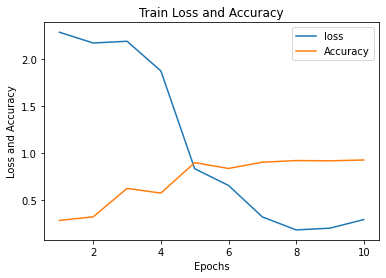

In [6]:
lr, num_epochs = 0.05, 10

trainCNN(net, train_loader,test_loader, num_epochs, lr, d2l.try_gpu())

1


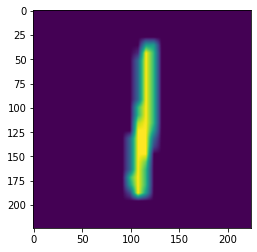

9


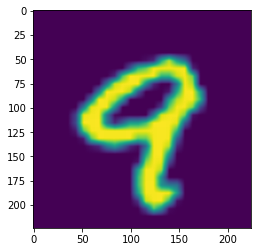

1


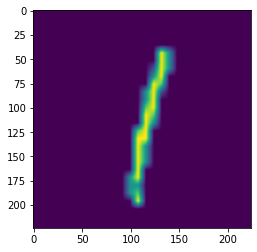

8


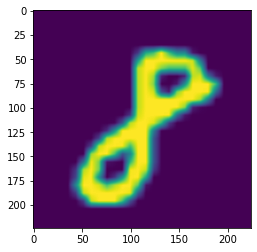

0


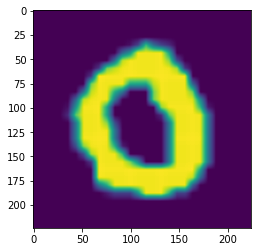

In [7]:
def showdemo(net, test_loader, n): 
    device = d2l.try_gpu()
    net.eval()
    X,y = next(iter(test_loader))
    if isinstance(X, list):
        X = [x.to(device) for x in X]
    else:
        X = X.to(device)   
    
    preds = net(X).argmax(axis=1)
    preds = preds.cpu()
    predlist = list(preds)
    titles = [pred.item() for pred in  predlist]
    X = X.cpu()
    for i in range(n):
        print(titles[i])
        plt.imshow(X[i].view(224, 224))
        plt.show()
    

showdemo(net,test_loader,5)

2


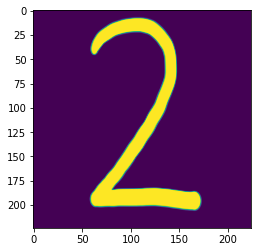

4


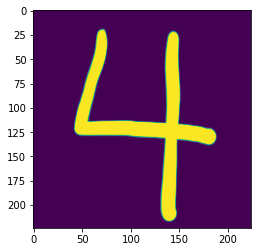

1


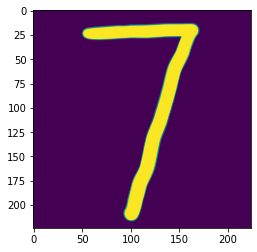

4


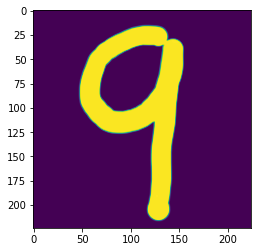

5


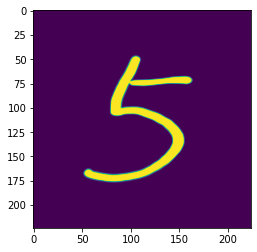

In [9]:
def readimg(net,path):
    net.eval()
    device = d2l.try_gpu()
    img = Image.open(path)
    #real image is 3 tunnel, convert it into black and white(2 tunnel)
    transform = transforms.Grayscale()
    img = transform(img)
    transform = transforms.Resize([224,224])
    img = transform(img)
    
    
    
    convert_tensor = transforms.ToTensor()
    testimg = convert_tensor(img)
    output = torch.rand(size=(1, 1, 224, 224), dtype=torch.float32)
    
    #image read by Image is in opposite value
    output[0] = 1-(testimg)
    
    
    if isinstance(testimg, list):
        output = [x.to(device) for x in output]
    else:
        output = output.to(device)
    
    pred = net(output).argmax(axis=1).item()
    
    print(pred)
    output=output.cpu()
    plt.imshow(output[0].view(224, 224))
    plt.show()
    
    
num_pic = 5
for i in range(num_pic):
    path = 'number'+str(i+1)+'.jpg'
    readimg(net,path)